# Model
The model used in this experiment is a CNN consisting of two 1-D convolutional layers, followed by a global average pooling layer and a softmax layer. The convolutional layers have 32 and 64 filters each. 
A global average pooling layer is used instead of flattening and it significantly reduces the dimensionality of the input going into the softmax layer. This way fully connected layers are not always necessary and the number of parameters in the model are kept to a minimum. 

# Data
The model is trained on data from the stationary growth phase using an integration time of 16ms. The model is classifying the species of a given bacteria sample.

In [1]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPool1D, GlobalAvgPool1D

In [2]:
os.getcwd()

'/home/anthony/summer-bursary-2018/bacteria'

In [3]:
os.listdir('data')

['Classific.py',
 'graphs.pdf',
 'growth_stages.csv',
 '16ms_32ms_growth_phase_spectra.csv',
 'bacteria_32ms.csv',
 'PC6allwavelengths.png',
 'bacteria_16ms.csv',
 'wavelengths.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv']

In [4]:
df_16ms = pd.read_csv('data/bacteria_16ms.csv', header=[0, 1, 2, 3], index_col=0)
df_16ms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, positive, bc, 01) to (stat, negative, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


In [5]:
df_16ms.describe()

growth_phase          lag                                                      \
gramness         positive                                                       
species                bc                                                       
replicate              01           02           03           04           05   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           340.917966   218.282554   410.265450   402.411758   147.930946   
std            517.453981   328.263253   632.792734   584.358827   213.381498   
min             -3.510400    -2.800760    -2.581292    -2.554170    -2.985820   
25%              3.738191     2.116139     3.614560     4.258268     3.017208   
50%             40.780240    27.023980    48.616896    58.972290    24.396270   
75%            496.754350   319.173550   571.801010   629.260350   223.730650   
max           1649.755000  1044.867000  2050.509445  1755.384000   670.982500   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              06           07           08           09           10   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           304.443366   690.243351   615.625463   508.217097   267.395909   
std            457.365956  1076.320701  1006.404767   829.675942   411.266389   
min             -3.429370    -2.280780    -4.327390    -3.340390   -24.324100   
25%              3.429760     4.382186     3.291279     3.093110    -1.435505   
50%             37.316280    78.138510    46.407810    41.594080    26.498390   
75%            446.739200   940.880800   775.154550   630.964700   401.714900   
max           1426.308000  3542.053000  3369.752000  2848.575000  1316.226000   

growth_phase     ...              stat                                         \
gramness         ...          positive                               negative   
species          ...                sa                                     se   
replicate        ...                06           07           08           01   
count            ...       1043.000000  1043.000000  1043.000000  1043.000000   
mean             ...       1319.282527  1617.105057  1424.455291   332.375709   
std              ...       2183.988762  2683.151537  2381.357464   525.271213   
min              ...        -18.529200    -2.563420    -1.462970    -2.361310   
25%              ...         11.080080    12.687795    10.883005     2.919165   
50%              ...        107.911900   130.242300   104.561900    33.991250   
75%              ...       1577.928000  1936.329500  1679.898000   436.948300   
max              ...       7512.713000  9235.687000  8223.580000  1713.175000   

growth_phase                                                                   \
gramness                                                                        
species                                                                         
replicate              02           03           04           05           06   
count         1043.000000  1043.000000  1043.000000  1043.000000  1043.000000   
mean           464.757981   346.619581   591.019431   944.666722   683.460369   
std            783.676339   589.041597  1030.124114  1631.945511  1174.686894   
min             -3.337340    -2.003951    -2.814100    -3.369360    -3.098660   
25%              3.433975     2.271594     7.036556     5.055340     3.809488   
50%             34.734540    22.254616    41.866360    52.880860    42.561820   
75%            533.983350   395.229638   603.002400  1030.629000   753.640300   
max           2670.119000  2010.552740  3632.655000  5669.533000  4091.082000   

growth_phase               
gramness                   
species                    
replicate              0

In [6]:
X = df_16ms['log'].T.values
# Scaling to [0.0, 1.0] improves convergence. 
# Relative scale between features are retained when done this way, rather than using sklearn's MinMaxScaler.
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max())
print(X[:5])

0.0 1.0
[[0.00203743 0.00212112 0.00213843 ... 0.00212978 0.00205475 0.00223655]
 [0.00209413 0.0020627  0.00213603 ... 0.00213603 0.00207318 0.00211508]
 [0.00209291 0.00210688 0.00217112 ... 0.00207057 0.00204264 0.00210688]
 [0.00219826 0.00213452 0.00205118 ... 0.00213452 0.00211001 0.0020904 ]
 [0.00218288 0.00212504 0.00210743 ... 0.00210492 0.00214264 0.00206719]]


In [7]:
X = np.expand_dims(X, axis=2)

print(X.shape)

(41, 1043, 1)


In [8]:
from sklearn.preprocessing import OneHotEncoder

y = df_16ms['log'].T.reset_index()['species']
y = y.values
y = y.reshape(-1, 1)

y[:5]

array([['bc'],
       ['bc'],
       ['bc'],
       ['bc'],
       ['bc']], dtype=object)

In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y, random_state=42)

X[:5]

array([[[0.00209431],
        [0.00209171],
        [0.00216175],
        ...,
        [0.00217472],
        [0.00205799],
        [0.00213581]],

       [[0.00207287],
        [0.00211774],
        [0.00214413],
        ...,
        [0.00213622],
        [0.00208079],
        [0.00208079]],

       [[0.00209963],
        [0.00208937],
        [0.00215095],
        ...,
        [0.0020791 ],
        [0.00215095],
        [0.0021099 ]],

       [[0.00216006],
        [0.00210745],
        [0.00206236],
        ...,
        [0.00213501],
        [0.00206987],
        [0.00207488]],

       [[0.00218288],
        [0.00212504],
        [0.00210743],
        ...,
        [0.00210492],
        [0.00214264],
        [0.00206719]]])

In [10]:
y[:5]

array([['pa'],
       ['ec'],
       ['bc'],
       ['pa'],
       ['bc']], dtype=object)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32, 1043, 1) (9, 1043, 1)
(32, 1) (9, 1)


In [12]:
N = X_train.shape[0]
W = X_train.shape[1]
C = X_train.shape[2]
print(N, W, C)

32 1043 1


In [13]:
k = len(np.unique(y))
print(k)

6


In [14]:
def get_model():
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='elu', input_shape=(W, C)))
    model.add(Conv1D(64, kernel_size=3, activation='elu'))

    model.add(GlobalAvgPool1D())
    model.add(Dense(k, activation='softmax'))

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.RMSprop(),
                  metrics=['accuracy'])

    return model

In [15]:
model = get_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,)

ohe = OneHotEncoder(sparse=False)
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.fit_transform(y_test)

history = model.fit(X_train, y_train_encoded,
          epochs=1000,
          validation_data=(X_test, y_test_encoded),
         callbacks=[early_stopping])

score = model.evaluate(X_test, y_test_encoded, verbose=0)
print('Test loss: %.2f' % score[0])
print('Test accuracy: %.2f' % score[1])

Train on 32 samples, validate on 9 samples
Epoch 1/1000
32/32 [==============================] - 1s 28ms/step - loss: 1.7982 - acc: 0.1250 - val_loss: 1.7821 - val_acc: 0.2222
Epoch 2/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.7748 - acc: 0.3125 - val_loss: 1.7729 - val_acc: 0.2222
Epoch 3/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.7586 - acc: 0.3125 - val_loss: 1.7649 - val_acc: 0.2222
Epoch 4/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.7443 - acc: 0.3125 - val_loss: 1.7576 - val_acc: 0.2222
Epoch 5/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.7309 - acc: 0.3125 - val_loss: 1.7510 - val_acc: 0.2222
Epoch 6/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.7180 - acc: 0.3125 - val_loss: 1.7449 - val_acc: 0.2222
Epoch 7/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.7057 - acc: 0.3125 - val_loss: 1.7396 - val_acc: 0.2222
Epoch 8/1000
32/32 [============

Epoch 63/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.3677 - acc: 0.5000 - val_loss: 1.4735 - val_acc: 0.4444
Epoch 64/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.3633 - acc: 0.5000 - val_loss: 1.4641 - val_acc: 0.4444
Epoch 65/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.3592 - acc: 0.5000 - val_loss: 1.4624 - val_acc: 0.4444
Epoch 66/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.3553 - acc: 0.5000 - val_loss: 1.4550 - val_acc: 0.4444
Epoch 67/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.3515 - acc: 0.5000 - val_loss: 1.4527 - val_acc: 0.4444
Epoch 68/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.3478 - acc: 0.5000 - val_loss: 1.4456 - val_acc: 0.4444
Epoch 69/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.3442 - acc: 0.5000 - val_loss: 1.4438 - val_acc: 0.4444
Epoch 70/1000
32/32 [==============================] - 0s 5ms/step - 

Epoch 125/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.2366 - acc: 0.5000 - val_loss: 1.3087 - val_acc: 0.3333
Epoch 126/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.2357 - acc: 0.5000 - val_loss: 1.2912 - val_acc: 0.3333
Epoch 127/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.2348 - acc: 0.5000 - val_loss: 1.3074 - val_acc: 0.3333
Epoch 128/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.2340 - acc: 0.5000 - val_loss: 1.2892 - val_acc: 0.3333
Epoch 129/1000
32/32 [==============================] - 0s 4ms/step - loss: 1.2332 - acc: 0.5000 - val_loss: 1.3061 - val_acc: 0.3333
Epoch 130/1000
32/32 [==============================] - 0s 3ms/step - loss: 1.2324 - acc: 0.5000 - val_loss: 1.2875 - val_acc: 0.3333
Epoch 131/1000
32/32 [==============================] - 0s 3ms/step - loss: 1.2316 - acc: 0.5000 - val_loss: 1.3048 - val_acc: 0.3333
Epoch 132/1000
32/32 [==============================] - 0s 4ms

Epoch 187/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.1974 - acc: 0.5312 - val_loss: 1.2894 - val_acc: 0.3333
Epoch 188/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.1968 - acc: 0.5312 - val_loss: 1.2668 - val_acc: 0.3333
Epoch 189/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.1963 - acc: 0.5312 - val_loss: 1.2897 - val_acc: 0.3333
Epoch 190/1000
32/32 [==============================] - 0s 6ms/step - loss: 1.1958 - acc: 0.5312 - val_loss: 1.2663 - val_acc: 0.3333
Epoch 191/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.1952 - acc: 0.5312 - val_loss: 1.2898 - val_acc: 0.3333
Epoch 192/1000
32/32 [==============================] - 0s 7ms/step - loss: 1.1947 - acc: 0.5312 - val_loss: 1.2659 - val_acc: 0.3333
Epoch 193/1000
32/32 [==============================] - 0s 5ms/step - loss: 1.1942 - acc: 0.5312 - val_loss: 1.2896 - val_acc: 0.3333
Epoch 194/1000
32/32 [==============================] - 0s 5ms

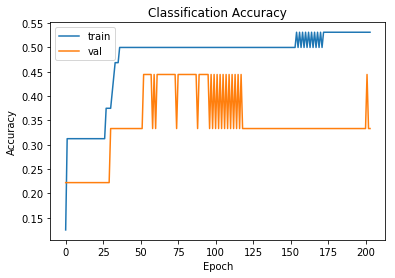

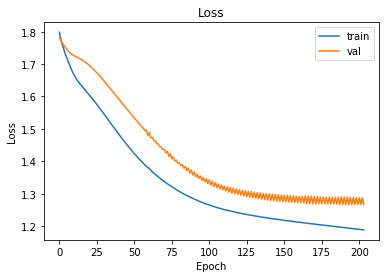

In [16]:
import matplotlib.pyplot as plt

%matplotlib inline

acc_history = history.history['acc']
val_acc_history = history.history['val_acc']
loss_history = history.history['loss']
val_loss_history = history.history['val_loss']

epochs = np.arange(len(acc_history))

plt.plot(epochs, acc_history, label='train')
plt.plot(epochs, val_acc_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy')
plt.legend()
plt.show()


plt.plot(epochs, loss_history, label='train')
plt.plot(epochs, val_loss_history, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [17]:
%%time

from sklearn.model_selection import RepeatedStratifiedKFold

n_splits = 3
n_repeats = 20
n_total = n_splits * n_repeats
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

score_history = []

print('Fitting %d folds over %d repetitions for a total of %d fits.' % (n_splits, n_repeats, n_total))

for i, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('\nIteration %d of %d' % (i + 1, n_total))
    
    X_train_cv = X[train_idx]
    y_train_cv = y[train_idx]
    X_val_cv = X[val_idx]
    y_val_cv= y[val_idx]

    # Encoding is not done directly on y so that the k-fold splitter doesn't throw an exception.
    ohe = OneHotEncoder(sparse=False)
    y_train_cv = ohe.fit_transform(y_train_cv)
    y_val_cv = ohe.fit_transform(y_val_cv)
    
    model = get_model() 

    history = model.fit(X_train_cv, y_train_cv,
              epochs=100,
              validation_data=(X_val_cv, y_val_cv))
    
    score_history.append(history.history)

    score = model.evaluate(X_val_cv, y_val_cv, verbose=0)
    print('Validation loss: %.2f' % score[0])
    print('Validation accuracy: %.2f' % score[1])

Fitting 3 folds over 20 repetitions for a total of 60 fits.

Iteration 1 of 60
Train on 26 samples, validate on 15 samples
Epoch 1/100
26/26 [==============================] - 1s 36ms/step - loss: 1.7915 - acc: 0.0769 - val_loss: 1.7710 - val_acc: 0.2667
Epoch 2/100
26/26 [==============================] - 0s 8ms/step - loss: 1.7682 - acc: 0.3077 - val_loss: 1.7562 - val_acc: 0.2667
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7514 - acc: 0.3077 - val_loss: 1.7432 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7366 - acc: 0.3077 - val_loss: 1.7313 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 8ms/step - loss: 1.7232 - acc: 0.3077 - val_loss: 1.7205 - val_acc: 0.2667
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7110 - acc: 0.3077 - val_loss: 1.7108 - val_acc: 0.2667
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6998 - acc: 0.3

Epoch 63/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3833 - acc: 0.4615 - val_loss: 1.4016 - val_acc: 0.4667
Epoch 64/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3779 - acc: 0.5000 - val_loss: 1.3968 - val_acc: 0.4667
Epoch 65/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3735 - acc: 0.5000 - val_loss: 1.3931 - val_acc: 0.4667
Epoch 66/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3696 - acc: 0.5000 - val_loss: 1.3891 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3659 - acc: 0.5000 - val_loss: 1.3855 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3622 - acc: 0.5000 - val_loss: 1.3818 - val_acc: 0.4667
Epoch 69/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3587 - acc: 0.5000 - val_loss: 1.3784 - val_acc: 0.4667
Epoch 70/100
26/26 [==============================] - 0s 8ms/step - loss: 1.

Epoch 25/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5709 - acc: 0.3077 - val_loss: 1.6412 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 7ms/step - loss: 1.5639 - acc: 0.3077 - val_loss: 1.6362 - val_acc: 0.3333
Epoch 27/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5568 - acc: 0.3077 - val_loss: 1.6311 - val_acc: 0.4000
Epoch 28/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5495 - acc: 0.3077 - val_loss: 1.6260 - val_acc: 0.4000
Epoch 29/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5420 - acc: 0.3077 - val_loss: 1.6209 - val_acc: 0.4000
Epoch 30/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5343 - acc: 0.3077 - val_loss: 1.6159 - val_acc: 0.4667
Epoch 31/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5265 - acc: 0.3462 - val_loss: 1.6109 - val_acc: 0.4667
Epoch 32/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

26/26 [==============================] - 0s 6ms/step - loss: 1.1621 - acc: 0.5000 - val_loss: 1.6148 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1580 - acc: 0.5000 - val_loss: 1.6145 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1539 - acc: 0.5000 - val_loss: 1.6242 - val_acc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1500 - acc: 0.5000 - val_loss: 1.6243 - val_acc: 0.4667
Epoch 91/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1462 - acc: 0.5000 - val_loss: 1.6346 - val_acc: 0.4667
Epoch 92/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1425 - acc: 0.5000 - val_loss: 1.6345 - val_acc: 0.4667
Epoch 93/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1388 - acc: 0.5000 - val_loss: 1.6456 - val_acc: 0.4667
Epoch 94/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1352 - acc: 0

Epoch 49/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4626 - acc: 0.4667 - val_loss: 1.4271 - val_acc: 0.5455
Epoch 50/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4573 - acc: 0.4667 - val_loss: 1.4221 - val_acc: 0.5455
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4520 - acc: 0.4667 - val_loss: 1.4140 - val_acc: 0.5455
Epoch 52/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4470 - acc: 0.4667 - val_loss: 1.4175 - val_acc: 0.5455
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4431 - acc: 0.4667 - val_loss: 1.4001 - val_acc: 0.4545
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4390 - acc: 0.4667 - val_loss: 1.4048 - val_acc: 0.5455
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4329 - acc: 0.4667 - val_loss: 1.3925 - val_acc: 0.5455
Epoch 56/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 11/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6634 - acc: 0.3077 - val_loss: 1.6853 - val_acc: 0.2667
Epoch 12/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6569 - acc: 0.3077 - val_loss: 1.6806 - val_acc: 0.2667
Epoch 13/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6511 - acc: 0.3077 - val_loss: 1.6761 - val_acc: 0.2667
Epoch 14/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6459 - acc: 0.3077 - val_loss: 1.6717 - val_acc: 0.2667
Epoch 15/100
26/26 [==============================] - 0s 4ms/step - loss: 1.6409 - acc: 0.3077 - val_loss: 1.6673 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6362 - acc: 0.3077 - val_loss: 1.6628 - val_acc: 0.2667
Epoch 17/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6315 - acc: 0.3077 - val_loss: 1.6583 - val_acc: 0.2667
Epoch 18/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 4ms/step - loss: 1.3330 - acc: 0.5000 - val_loss: 1.3776 - val_acc: 0.4667
Epoch 74/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3295 - acc: 0.5000 - val_loss: 1.3740 - val_acc: 0.4667
Epoch 75/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3262 - acc: 0.5000 - val_loss: 1.3720 - val_acc: 0.4667
Epoch 76/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3229 - acc: 0.5000 - val_loss: 1.3686 - val_acc: 0.4667
Epoch 77/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3199 - acc: 0.5000 - val_loss: 1.3669 - val_acc: 0.4667
Epoch 78/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3169 - acc: 0.5000 - val_loss: 1.3636 - val_acc: 0.4667
Epoch 79/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3140 - acc: 0.5000 - val_loss: 1.3623 - val_acc: 0.4667
Epoch 80/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3112 - acc: 0

Epoch 35/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5010 - acc: 0.4231 - val_loss: 1.6205 - val_acc: 0.4667
Epoch 36/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4930 - acc: 0.4615 - val_loss: 1.6170 - val_acc: 0.4667
Epoch 37/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4849 - acc: 0.4615 - val_loss: 1.6136 - val_acc: 0.4667
Epoch 38/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4769 - acc: 0.4615 - val_loss: 1.6103 - val_acc: 0.4667
Epoch 39/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4688 - acc: 0.4615 - val_loss: 1.6072 - val_acc: 0.4667
Epoch 40/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4608 - acc: 0.4615 - val_loss: 1.6042 - val_acc: 0.4667
Epoch 41/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4528 - acc: 0.4615 - val_loss: 1.6014 - val_acc: 0.4667
Epoch 42/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.1477 - acc: 0.5000 - val_loss: 1.6852 - val_acc: 0.4667
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1448 - acc: 0.5000 - val_loss: 1.6865 - val_acc: 0.4667
Epoch 99/100
26/26 [==============================] - 0s 4ms/step - loss: 1.1420 - acc: 0.5000 - val_loss: 1.6954 - val_acc: 0.4667
Epoch 100/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1392 - acc: 0.5000 - val_loss: 1.6962 - val_acc: 0.4667
Validation loss: 1.70
Validation accuracy: 0.47

Iteration 6 of 60
Train on 30 samples, validate on 11 samples
Epoch 1/100
30/30 [==============================] - 1s 37ms/step - loss: 1.7893 - acc: 0.2000 - val_loss: 1.7592 - val_acc: 0.3636
Epoch 2/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7690 - acc: 0.2667 - val_loss: 1.7394 - val_acc: 0.3636
Epoch 3/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7545 - acc: 0.2667 - val_loss: 1.72

Epoch 59/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4117 - acc: 0.4667 - val_loss: 1.3435 - val_acc: 0.5455
Epoch 60/100
30/30 [==============================] - 0s 3ms/step - loss: 1.4073 - acc: 0.4667 - val_loss: 1.3374 - val_acc: 0.5455
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4029 - acc: 0.4667 - val_loss: 1.3335 - val_acc: 0.5455
Epoch 62/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3986 - acc: 0.4667 - val_loss: 1.3274 - val_acc: 0.5455
Epoch 63/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3944 - acc: 0.4667 - val_loss: 1.3243 - val_acc: 0.5455
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3903 - acc: 0.4667 - val_loss: 1.3178 - val_acc: 0.5455
Epoch 65/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3865 - acc: 0.4667 - val_loss: 1.3161 - val_acc: 0.5455
Epoch 66/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

Epoch 21/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6384 - acc: 0.3077 - val_loss: 1.6435 - val_acc: 0.2667
Epoch 22/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6340 - acc: 0.3077 - val_loss: 1.6390 - val_acc: 0.2667
Epoch 23/100
26/26 [==============================] - 0s 9ms/step - loss: 1.6295 - acc: 0.3077 - val_loss: 1.6344 - val_acc: 0.2667
Epoch 24/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6249 - acc: 0.3077 - val_loss: 1.6297 - val_acc: 0.2667
Epoch 25/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6201 - acc: 0.3077 - val_loss: 1.6248 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6152 - acc: 0.3077 - val_loss: 1.6198 - val_acc: 0.2667
Epoch 27/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6101 - acc: 0.3077 - val_loss: 1.6147 - val_acc: 0.2667
Epoch 28/100
26/26 [==============================] - 0s 7ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.3162 - acc: 0.4615 - val_loss: 1.4211 - val_acc: 0.4667
Epoch 84/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3129 - acc: 0.5000 - val_loss: 1.4064 - val_acc: 0.4667
Epoch 85/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3097 - acc: 0.4615 - val_loss: 1.4211 - val_acc: 0.4667
Epoch 86/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3064 - acc: 0.5000 - val_loss: 1.4047 - val_acc: 0.4667
Epoch 87/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3032 - acc: 0.4615 - val_loss: 1.4196 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2999 - acc: 0.5000 - val_loss: 1.4044 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2967 - acc: 0.4615 - val_loss: 1.4179 - val_acc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2936 - acc: 0

Epoch 45/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3943 - acc: 0.5000 - val_loss: 1.6563 - val_acc: 0.4000
Epoch 46/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3859 - acc: 0.5000 - val_loss: 1.6563 - val_acc: 0.4000
Epoch 47/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3776 - acc: 0.5000 - val_loss: 1.6565 - val_acc: 0.4000
Epoch 48/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3693 - acc: 0.5000 - val_loss: 1.6569 - val_acc: 0.4000
Epoch 49/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3612 - acc: 0.5000 - val_loss: 1.6575 - val_acc: 0.4000
Epoch 50/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3531 - acc: 0.5000 - val_loss: 1.6582 - val_acc: 0.4667
Epoch 51/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3452 - acc: 0.5000 - val_loss: 1.6592 - val_acc: 0.4667
Epoch 52/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7112 - acc: 0.2667 - val_loss: 1.6730 - val_acc: 0.3636
Epoch 8/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7023 - acc: 0.2667 - val_loss: 1.6618 - val_acc: 0.3636
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6942 - acc: 0.2667 - val_loss: 1.6519 - val_acc: 0.3636
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6868 - acc: 0.2667 - val_loss: 1.6432 - val_acc: 0.3636
Epoch 11/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6801 - acc: 0.2667 - val_loss: 1.6356 - val_acc: 0.3636
Epoch 12/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6738 - acc: 0.2667 - val_loss: 1.6288 - val_acc: 0.3636
Epoch 13/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6679 - acc: 0.2667 - val_loss: 1.6228 - val_acc: 0.3636
Epoch 14/100
30/30 [==============================] - 0s 6ms/step - loss: 1.662

30/30 [==============================] - 0s 4ms/step - loss: 1.3709 - acc: 0.4667 - val_loss: 1.3131 - val_acc: 0.5455
Epoch 70/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3677 - acc: 0.4667 - val_loss: 1.3206 - val_acc: 0.5455
Epoch 71/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3642 - acc: 0.4667 - val_loss: 1.3061 - val_acc: 0.5455
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3609 - acc: 0.4667 - val_loss: 1.3098 - val_acc: 0.5455
Epoch 73/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3577 - acc: 0.4667 - val_loss: 1.2989 - val_acc: 0.5455
Epoch 74/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3547 - acc: 0.4667 - val_loss: 1.3008 - val_acc: 0.5455
Epoch 75/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3519 - acc: 0.4667 - val_loss: 1.2912 - val_acc: 0.5455
Epoch 76/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3491 - acc: 0

Epoch 31/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5307 - acc: 0.3462 - val_loss: 1.6578 - val_acc: 0.3333
Epoch 32/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5228 - acc: 0.4231 - val_loss: 1.6544 - val_acc: 0.3333
Epoch 33/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5148 - acc: 0.4615 - val_loss: 1.6510 - val_acc: 0.4000
Epoch 34/100
26/26 [==============================] - 0s 4ms/step - loss: 1.5067 - acc: 0.4615 - val_loss: 1.6478 - val_acc: 0.4000
Epoch 35/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4986 - acc: 0.4615 - val_loss: 1.6446 - val_acc: 0.4000
Epoch 36/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4904 - acc: 0.4615 - val_loss: 1.6415 - val_acc: 0.4667
Epoch 37/100
26/26 [==============================] - 0s 10ms/step - loss: 1.4821 - acc: 0.4615 - val_loss: 1.6385 - val_acc: 0.4667
Epoch 38/100
26/26 [==============================] - 0s 10ms/step - loss: 

26/26 [==============================] - 0s 5ms/step - loss: 1.1473 - acc: 0.5000 - val_loss: 1.6842 - val_acc: 0.4667
Epoch 94/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1441 - acc: 0.5000 - val_loss: 1.6797 - val_acc: 0.4667
Epoch 95/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1409 - acc: 0.5000 - val_loss: 1.6936 - val_acc: 0.4667
Epoch 96/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1378 - acc: 0.5000 - val_loss: 1.6882 - val_acc: 0.4667
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1348 - acc: 0.5000 - val_loss: 1.7037 - val_acc: 0.4667
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1319 - acc: 0.5000 - val_loss: 1.6971 - val_acc: 0.4667
Epoch 99/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1289 - acc: 0.5000 - val_loss: 1.7136 - val_acc: 0.4667
Epoch 100/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1261 - acc: 

Epoch 55/100
26/26 [==============================] - 0s 9ms/step - loss: 1.4205 - acc: 0.5000 - val_loss: 1.4598 - val_acc: 0.4000
Epoch 56/100
26/26 [==============================] - 0s 8ms/step - loss: 1.4158 - acc: 0.5000 - val_loss: 1.4574 - val_acc: 0.4667
Epoch 57/100
26/26 [==============================] - 0s 9ms/step - loss: 1.4119 - acc: 0.5000 - val_loss: 1.4534 - val_acc: 0.4000
Epoch 58/100
26/26 [==============================] - 0s 8ms/step - loss: 1.4091 - acc: 0.5000 - val_loss: 1.4506 - val_acc: 0.4667
Epoch 59/100
26/26 [==============================] - 0s 8ms/step - loss: 1.4033 - acc: 0.5000 - val_loss: 1.4446 - val_acc: 0.4000
Epoch 60/100
26/26 [==============================] - 0s 9ms/step - loss: 1.3983 - acc: 0.5000 - val_loss: 1.4417 - val_acc: 0.4667
Epoch 61/100
26/26 [==============================] - 0s 9ms/step - loss: 1.3938 - acc: 0.5000 - val_loss: 1.4374 - val_acc: 0.4000
Epoch 62/100
26/26 [==============================] - 0s 9ms/step - loss: 1.

Epoch 17/100
30/30 [==============================] - 0s 8ms/step - loss: 1.6458 - acc: 0.2667 - val_loss: 1.5760 - val_acc: 0.3636
Epoch 18/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6402 - acc: 0.2667 - val_loss: 1.5694 - val_acc: 0.3636
Epoch 19/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6347 - acc: 0.2667 - val_loss: 1.5629 - val_acc: 0.4545
Epoch 20/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6292 - acc: 0.2667 - val_loss: 1.5564 - val_acc: 0.4545
Epoch 21/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6236 - acc: 0.3000 - val_loss: 1.5500 - val_acc: 0.4545
Epoch 22/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6179 - acc: 0.3000 - val_loss: 1.5435 - val_acc: 0.4545
Epoch 23/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6122 - acc: 0.3000 - val_loss: 1.5370 - val_acc: 0.5455
Epoch 24/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 7ms/step - loss: 1.3533 - acc: 0.4667 - val_loss: 1.2464 - val_acc: 0.5455
Epoch 80/100
30/30 [==============================] - 0s 9ms/step - loss: 1.3508 - acc: 0.4667 - val_loss: 1.2543 - val_acc: 0.5455
Epoch 81/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3483 - acc: 0.4667 - val_loss: 1.2413 - val_acc: 0.5455
Epoch 82/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3458 - acc: 0.4667 - val_loss: 1.2503 - val_acc: 0.5455
Epoch 83/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3433 - acc: 0.4667 - val_loss: 1.2373 - val_acc: 0.5455
Epoch 84/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3408 - acc: 0.4667 - val_loss: 1.2455 - val_acc: 0.5455
Epoch 85/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3383 - acc: 0.4667 - val_loss: 1.2339 - val_acc: 0.5455
Epoch 86/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3359 - acc: 0

Epoch 41/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5098 - acc: 0.5000 - val_loss: 1.5508 - val_acc: 0.4000
Epoch 42/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5037 - acc: 0.5000 - val_loss: 1.5454 - val_acc: 0.4000
Epoch 43/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4977 - acc: 0.5000 - val_loss: 1.5400 - val_acc: 0.4000
Epoch 44/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4916 - acc: 0.5000 - val_loss: 1.5347 - val_acc: 0.4000
Epoch 45/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4856 - acc: 0.5000 - val_loss: 1.5293 - val_acc: 0.4000
Epoch 46/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4797 - acc: 0.5000 - val_loss: 1.5240 - val_acc: 0.4000
Epoch 47/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4738 - acc: 0.5000 - val_loss: 1.5188 - val_acc: 0.4000
Epoch 48/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7455 - acc: 0.3077 - val_loss: 1.7372 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7305 - acc: 0.3077 - val_loss: 1.7256 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7169 - acc: 0.3077 - val_loss: 1.7151 - val_acc: 0.2667
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7044 - acc: 0.3077 - val_loss: 1.7054 - val_acc: 0.2667
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6931 - acc: 0.3077 - val_loss: 1.6968 - val_acc: 0.2667
Epoch 8/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6829 - acc: 0.3077 - val_loss: 1.6890 - val_acc: 0.2667
Epoch 9/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6739 - acc: 0.3077 - val_loss: 1.6821 - val_acc: 0.2667
Epoch 10/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6659 - 

Epoch 66/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3800 - acc: 0.5000 - val_loss: 1.3666 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3767 - acc: 0.5000 - val_loss: 1.3574 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3736 - acc: 0.5000 - val_loss: 1.3609 - val_acc: 0.4667
Epoch 69/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3706 - acc: 0.5000 - val_loss: 1.3487 - val_acc: 0.4667
Epoch 70/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3676 - acc: 0.5000 - val_loss: 1.3534 - val_acc: 0.4667
Epoch 71/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3643 - acc: 0.5000 - val_loss: 1.3416 - val_acc: 0.4667
Epoch 72/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3610 - acc: 0.5000 - val_loss: 1.3445 - val_acc: 0.4667
Epoch 73/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 28/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5837 - acc: 0.3667 - val_loss: 1.5865 - val_acc: 0.5455
Epoch 29/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5760 - acc: 0.4000 - val_loss: 1.5837 - val_acc: 0.5455
Epoch 30/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5681 - acc: 0.4000 - val_loss: 1.5810 - val_acc: 0.5455
Epoch 31/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5602 - acc: 0.4333 - val_loss: 1.5785 - val_acc: 0.5455
Epoch 32/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5521 - acc: 0.4333 - val_loss: 1.5762 - val_acc: 0.5455
Epoch 33/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5440 - acc: 0.4333 - val_loss: 1.5741 - val_acc: 0.5455
Epoch 34/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5359 - acc: 0.4333 - val_loss: 1.5722 - val_acc: 0.5455
Epoch 35/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

Epoch 91/100
30/30 [==============================] - 0s 6ms/step - loss: 1.1795 - acc: 0.4667 - val_loss: 1.8521 - val_acc: 0.5455
Epoch 92/100
30/30 [==============================] - 0s 7ms/step - loss: 1.1758 - acc: 0.4667 - val_loss: 1.8454 - val_acc: 0.5455
Epoch 93/100
30/30 [==============================] - 0s 5ms/step - loss: 1.1721 - acc: 0.4667 - val_loss: 1.8736 - val_acc: 0.5455
Epoch 94/100
30/30 [==============================] - 0s 4ms/step - loss: 1.1685 - acc: 0.4667 - val_loss: 1.8643 - val_acc: 0.5455
Epoch 95/100
30/30 [==============================] - 0s 8ms/step - loss: 1.1650 - acc: 0.4667 - val_loss: 1.8954 - val_acc: 0.5455
Epoch 96/100
30/30 [==============================] - 0s 8ms/step - loss: 1.1615 - acc: 0.4667 - val_loss: 1.8843 - val_acc: 0.5455
Epoch 97/100
30/30 [==============================] - 0s 5ms/step - loss: 1.1581 - acc: 0.4667 - val_loss: 1.9167 - val_acc: 0.5455
Epoch 98/100
30/30 [==============================] - 0s 8ms/step - loss: 1.

Epoch 53/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4486 - acc: 0.5000 - val_loss: 1.4927 - val_acc: 0.4667
Epoch 54/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4426 - acc: 0.5000 - val_loss: 1.4895 - val_acc: 0.4667
Epoch 55/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4368 - acc: 0.5000 - val_loss: 1.4864 - val_acc: 0.4667
Epoch 56/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4310 - acc: 0.5000 - val_loss: 1.4835 - val_acc: 0.4667
Epoch 57/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4252 - acc: 0.5000 - val_loss: 1.4808 - val_acc: 0.4667
Epoch 58/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4195 - acc: 0.5000 - val_loss: 1.4780 - val_acc: 0.4667
Epoch 59/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4139 - acc: 0.5000 - val_loss: 1.4759 - val_acc: 0.4667
Epoch 60/100
26/26 [==============================] - 0s 7ms/step - loss: 1.

Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6180 - acc: 0.3077 - val_loss: 1.6876 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6112 - acc: 0.3077 - val_loss: 1.6851 - val_acc: 0.2667
Epoch 17/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6046 - acc: 0.3077 - val_loss: 1.6825 - val_acc: 0.2667
Epoch 18/100
26/26 [==============================] - 0s 9ms/step - loss: 1.5980 - acc: 0.3077 - val_loss: 1.6796 - val_acc: 0.2667
Epoch 19/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5913 - acc: 0.3077 - val_loss: 1.6764 - val_acc: 0.2667
Epoch 20/100
26/26 [==============================] - 0s 10ms/step - loss: 1.5844 - acc: 0.3077 - val_loss: 1.6731 - val_acc: 0.2667
Epoch 21/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5774 - acc: 0.3077 - val_loss: 1.6695 - val_acc: 0.2667
Epoch 22/100
26/26 [==============================] - 0s 7ms/step - loss: 1

26/26 [==============================] - 0s 5ms/step - loss: 1.1785 - acc: 0.5000 - val_loss: 1.6551 - val_acc: 0.4667
Epoch 78/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1740 - acc: 0.5000 - val_loss: 1.6476 - val_acc: 0.4667
Epoch 79/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1697 - acc: 0.5000 - val_loss: 1.6647 - val_acc: 0.4667
Epoch 80/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1655 - acc: 0.5000 - val_loss: 1.6552 - val_acc: 0.4667
Epoch 81/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1614 - acc: 0.5000 - val_loss: 1.6762 - val_acc: 0.4667
Epoch 82/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1574 - acc: 0.5000 - val_loss: 1.6626 - val_acc: 0.4667
Epoch 83/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1535 - acc: 0.5000 - val_loss: 1.6886 - val_acc: 0.4667
Epoch 84/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1497 - acc: 0

Epoch 39/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5175 - acc: 0.4667 - val_loss: 1.4751 - val_acc: 0.5455
Epoch 40/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5115 - acc: 0.4667 - val_loss: 1.4689 - val_acc: 0.5455
Epoch 41/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5055 - acc: 0.4667 - val_loss: 1.4628 - val_acc: 0.5455
Epoch 42/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4996 - acc: 0.4667 - val_loss: 1.4567 - val_acc: 0.5455
Epoch 43/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4938 - acc: 0.4667 - val_loss: 1.4506 - val_acc: 0.5455
Epoch 44/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4880 - acc: 0.4667 - val_loss: 1.4444 - val_acc: 0.5455
Epoch 45/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4823 - acc: 0.4667 - val_loss: 1.4383 - val_acc: 0.5455
Epoch 46/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Train on 26 samples, validate on 15 samples
Epoch 1/100
26/26 [==============================] - 2s 76ms/step - loss: 1.7880 - acc: 0.3846 - val_loss: 1.7712 - val_acc: 0.2667
Epoch 2/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7641 - acc: 0.3077 - val_loss: 1.7563 - val_acc: 0.2667
Epoch 3/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7464 - acc: 0.3077 - val_loss: 1.7432 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 1.7307 - acc: 0.3077 - val_loss: 1.7314 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7163 - acc: 0.3077 - val_loss: 1.7209 - val_acc: 0.2667
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7033 - acc: 0.3077 - val_loss: 1.7118 - val_acc: 0.2667
Epoch 7/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6918 - acc: 0.3077 - val_loss: 1.7042 - val_acc: 0.2667
Epoch 8/100
26/26 [===================

Epoch 63/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3835 - acc: 0.5000 - val_loss: 1.4313 - val_acc: 0.4667
Epoch 64/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3788 - acc: 0.5000 - val_loss: 1.4283 - val_acc: 0.4667
Epoch 65/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3744 - acc: 0.5000 - val_loss: 1.4245 - val_acc: 0.4667
Epoch 66/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3700 - acc: 0.5000 - val_loss: 1.4216 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3657 - acc: 0.5000 - val_loss: 1.4180 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3614 - acc: 0.5000 - val_loss: 1.4155 - val_acc: 0.4667
Epoch 69/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3573 - acc: 0.5000 - val_loss: 1.4119 - val_acc: 0.4667
Epoch 70/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

Epoch 25/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5426 - acc: 0.3077 - val_loss: 1.6760 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5346 - acc: 0.3077 - val_loss: 1.6735 - val_acc: 0.2667
Epoch 27/100
26/26 [==============================] - 0s 4ms/step - loss: 1.5265 - acc: 0.3462 - val_loss: 1.6710 - val_acc: 0.2667
Epoch 28/100
26/26 [==============================] - 0s 4ms/step - loss: 1.5182 - acc: 0.3846 - val_loss: 1.6685 - val_acc: 0.2667
Epoch 29/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5097 - acc: 0.3846 - val_loss: 1.6661 - val_acc: 0.2667
Epoch 30/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5012 - acc: 0.3846 - val_loss: 1.6638 - val_acc: 0.2667
Epoch 31/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4925 - acc: 0.4231 - val_loss: 1.6616 - val_acc: 0.3333
Epoch 32/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.1429 - acc: 0.5000 - val_loss: 1.7364 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1398 - acc: 0.5000 - val_loss: 1.7366 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1368 - acc: 0.5000 - val_loss: 1.7465 - val_acc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 8ms/step - loss: 1.1340 - acc: 0.5000 - val_loss: 1.7454 - val_acc: 0.4667
Epoch 91/100
26/26 [==============================] - 0s 10ms/step - loss: 1.1312 - acc: 0.5000 - val_loss: 1.7568 - val_acc: 0.4667
Epoch 92/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1284 - acc: 0.5000 - val_loss: 1.7548 - val_acc: 0.4667
Epoch 93/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1256 - acc: 0.5000 - val_loss: 1.7664 - val_acc: 0.4667
Epoch 94/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1229 - acc: 

Epoch 49/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4951 - acc: 0.4667 - val_loss: 1.3454 - val_acc: 0.5455
Epoch 50/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4897 - acc: 0.4667 - val_loss: 1.3386 - val_acc: 0.5455
Epoch 51/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4843 - acc: 0.4667 - val_loss: 1.3319 - val_acc: 0.5455
Epoch 52/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4790 - acc: 0.4667 - val_loss: 1.3253 - val_acc: 0.5455
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4737 - acc: 0.4667 - val_loss: 1.3190 - val_acc: 0.5455
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4685 - acc: 0.4667 - val_loss: 1.3122 - val_acc: 0.5455
Epoch 55/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4633 - acc: 0.4667 - val_loss: 1.3080 - val_acc: 0.5455
Epoch 56/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 11/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6612 - acc: 0.3077 - val_loss: 1.6846 - val_acc: 0.2667
Epoch 12/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6547 - acc: 0.3077 - val_loss: 1.6806 - val_acc: 0.2667
Epoch 13/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6491 - acc: 0.3077 - val_loss: 1.6770 - val_acc: 0.2667
Epoch 14/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6441 - acc: 0.3077 - val_loss: 1.6736 - val_acc: 0.2667
Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6396 - acc: 0.3077 - val_loss: 1.6703 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6354 - acc: 0.3077 - val_loss: 1.6669 - val_acc: 0.2667
Epoch 17/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6313 - acc: 0.3077 - val_loss: 1.6634 - val_acc: 0.2667
Epoch 18/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 6ms/step - loss: 1.3245 - acc: 0.5000 - val_loss: 1.4041 - val_acc: 0.4667
Epoch 74/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3208 - acc: 0.5000 - val_loss: 1.3972 - val_acc: 0.4667
Epoch 75/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3172 - acc: 0.5000 - val_loss: 1.4013 - val_acc: 0.4000
Epoch 76/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3139 - acc: 0.5000 - val_loss: 1.3905 - val_acc: 0.4667
Epoch 77/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3107 - acc: 0.5000 - val_loss: 1.3989 - val_acc: 0.4000
Epoch 78/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3075 - acc: 0.5000 - val_loss: 1.3860 - val_acc: 0.4667
Epoch 79/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3040 - acc: 0.5000 - val_loss: 1.3926 - val_acc: 0.4000
Epoch 80/100
26/26 [==============================] - 0s 8ms/step - loss: 1.3005 - acc: 0

Epoch 35/100
26/26 [==============================] - 0s 10ms/step - loss: 1.4918 - acc: 0.4231 - val_loss: 1.6100 - val_acc: 0.4667
Epoch 36/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4840 - acc: 0.4615 - val_loss: 1.6064 - val_acc: 0.4667
Epoch 37/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4762 - acc: 0.4615 - val_loss: 1.6029 - val_acc: 0.4667
Epoch 38/100
26/26 [==============================] - 0s 9ms/step - loss: 1.4685 - acc: 0.4615 - val_loss: 1.5996 - val_acc: 0.4667
Epoch 39/100
26/26 [==============================] - 0s 8ms/step - loss: 1.4607 - acc: 0.4615 - val_loss: 1.5963 - val_acc: 0.4667
Epoch 40/100
26/26 [==============================] - 0s 9ms/step - loss: 1.4530 - acc: 0.4615 - val_loss: 1.5932 - val_acc: 0.4667
Epoch 41/100
26/26 [==============================] - 0s 10ms/step - loss: 1.4453 - acc: 0.4615 - val_loss: 1.5902 - val_acc: 0.4667
Epoch 42/100
26/26 [==============================] - 0s 9ms/step - loss: 

26/26 [==============================] - 0s 9ms/step - loss: 1.1506 - acc: 0.5000 - val_loss: 1.6328 - val_acc: 0.4667
Epoch 98/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1477 - acc: 0.5000 - val_loss: 1.6271 - val_acc: 0.4667
Epoch 99/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1448 - acc: 0.5000 - val_loss: 1.6405 - val_acc: 0.4667
Epoch 100/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1420 - acc: 0.5000 - val_loss: 1.6356 - val_acc: 0.4667
Validation loss: 1.64
Validation accuracy: 0.47

Iteration 24 of 60
Train on 30 samples, validate on 11 samples
Epoch 1/100
30/30 [==============================] - 3s 84ms/step - loss: 1.7921 - acc: 0.2000 - val_loss: 1.7716 - val_acc: 0.3636
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7753 - acc: 0.2667 - val_loss: 1.7543 - val_acc: 0.3636
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7625 - acc: 0.2667 - val_loss: 1.7

Epoch 59/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4562 - acc: 0.4667 - val_loss: 1.3802 - val_acc: 0.5455
Epoch 60/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4508 - acc: 0.4667 - val_loss: 1.3864 - val_acc: 0.5455
Epoch 61/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4459 - acc: 0.4667 - val_loss: 1.3736 - val_acc: 0.5455
Epoch 62/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4413 - acc: 0.4667 - val_loss: 1.3744 - val_acc: 0.5455
Epoch 63/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4367 - acc: 0.4667 - val_loss: 1.3644 - val_acc: 0.5455
Epoch 64/100
30/30 [==============================] - 0s 6ms/step - loss: 1.4322 - acc: 0.4667 - val_loss: 1.3645 - val_acc: 0.5455
Epoch 65/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4278 - acc: 0.4667 - val_loss: 1.3542 - val_acc: 0.5455
Epoch 66/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 21/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6218 - acc: 0.3077 - val_loss: 1.6435 - val_acc: 0.2667
Epoch 22/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6170 - acc: 0.3077 - val_loss: 1.6391 - val_acc: 0.2667
Epoch 23/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6121 - acc: 0.3077 - val_loss: 1.6344 - val_acc: 0.2667
Epoch 24/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6070 - acc: 0.3077 - val_loss: 1.6296 - val_acc: 0.2667
Epoch 25/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6016 - acc: 0.3077 - val_loss: 1.6246 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5961 - acc: 0.3077 - val_loss: 1.6195 - val_acc: 0.2667
Epoch 27/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5905 - acc: 0.3077 - val_loss: 1.6142 - val_acc: 0.3333
Epoch 28/100
26/26 [==============================] - 0s 7ms/step - loss: 1.

26/26 [==============================] - 0s 6ms/step - loss: 1.2943 - acc: 0.5000 - val_loss: 1.4226 - val_acc: 0.4667
Epoch 84/100
26/26 [==============================] - 0s 7ms/step - loss: 1.2913 - acc: 0.5000 - val_loss: 1.4350 - val_acc: 0.4667
Epoch 85/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2883 - acc: 0.5000 - val_loss: 1.4212 - val_acc: 0.4667
Epoch 86/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2854 - acc: 0.5000 - val_loss: 1.4351 - val_acc: 0.4667
Epoch 87/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2825 - acc: 0.5000 - val_loss: 1.4213 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 7ms/step - loss: 1.2795 - acc: 0.5000 - val_loss: 1.4341 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2767 - acc: 0.5000 - val_loss: 1.4221 - val_acc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2739 - acc: 0

Epoch 45/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4826 - acc: 0.5000 - val_loss: 1.4493 - val_acc: 0.4000
Epoch 46/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4773 - acc: 0.5000 - val_loss: 1.4426 - val_acc: 0.4000
Epoch 47/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4720 - acc: 0.5000 - val_loss: 1.4359 - val_acc: 0.4000
Epoch 48/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4668 - acc: 0.5000 - val_loss: 1.4293 - val_acc: 0.4000
Epoch 49/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4616 - acc: 0.5000 - val_loss: 1.4228 - val_acc: 0.4000
Epoch 50/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4566 - acc: 0.5000 - val_loss: 1.4164 - val_acc: 0.4667
Epoch 51/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4516 - acc: 0.5000 - val_loss: 1.4100 - val_acc: 0.4667
Epoch 52/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

Epoch 7/100
30/30 [==============================] - 0s 6ms/step - loss: 1.7174 - acc: 0.2667 - val_loss: 1.6859 - val_acc: 0.3636
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7079 - acc: 0.2667 - val_loss: 1.6760 - val_acc: 0.3636
Epoch 9/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6991 - acc: 0.2667 - val_loss: 1.6672 - val_acc: 0.3636
Epoch 10/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6909 - acc: 0.2667 - val_loss: 1.6596 - val_acc: 0.3636
Epoch 11/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6834 - acc: 0.2667 - val_loss: 1.6530 - val_acc: 0.3636
Epoch 12/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6764 - acc: 0.2667 - val_loss: 1.6475 - val_acc: 0.3636
Epoch 13/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6699 - acc: 0.2667 - val_loss: 1.6429 - val_acc: 0.3636
Epoch 14/100
30/30 [==============================] - 0s 6ms/step - loss: 1.663

30/30 [==============================] - 0s 8ms/step - loss: 1.2551 - acc: 0.4667 - val_loss: 1.6548 - val_acc: 0.5455
Epoch 70/100
30/30 [==============================] - 0s 8ms/step - loss: 1.2496 - acc: 0.4667 - val_loss: 1.6688 - val_acc: 0.5455
Epoch 71/100
30/30 [==============================] - 0s 7ms/step - loss: 1.2440 - acc: 0.4667 - val_loss: 1.6661 - val_acc: 0.5455
Epoch 72/100
30/30 [==============================] - 0s 8ms/step - loss: 1.2384 - acc: 0.4667 - val_loss: 1.6787 - val_acc: 0.5455
Epoch 73/100
30/30 [==============================] - 0s 10ms/step - loss: 1.2330 - acc: 0.4667 - val_loss: 1.6785 - val_acc: 0.5455
Epoch 74/100
30/30 [==============================] - 0s 9ms/step - loss: 1.2277 - acc: 0.4667 - val_loss: 1.6900 - val_acc: 0.5455
Epoch 75/100
30/30 [==============================] - 0s 6ms/step - loss: 1.2227 - acc: 0.4667 - val_loss: 1.6911 - val_acc: 0.5455
Epoch 76/100
30/30 [==============================] - 0s 8ms/step - loss: 1.2177 - acc: 

Epoch 31/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5623 - acc: 0.3846 - val_loss: 1.5942 - val_acc: 0.4000
Epoch 32/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5558 - acc: 0.4231 - val_loss: 1.5886 - val_acc: 0.4000
Epoch 33/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5491 - acc: 0.4615 - val_loss: 1.5830 - val_acc: 0.4000
Epoch 34/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5425 - acc: 0.4615 - val_loss: 1.5775 - val_acc: 0.4000
Epoch 35/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5357 - acc: 0.4615 - val_loss: 1.5720 - val_acc: 0.4667
Epoch 36/100
26/26 [==============================] - 0s 9ms/step - loss: 1.5290 - acc: 0.4615 - val_loss: 1.5666 - val_acc: 0.4667
Epoch 37/100
26/26 [==============================] - 0s 7ms/step - loss: 1.5223 - acc: 0.4615 - val_loss: 1.5613 - val_acc: 0.4667
Epoch 38/100
26/26 [==============================] - 0s 8ms/step - loss: 1.

26/26 [==============================] - 0s 6ms/step - loss: 1.2594 - acc: 0.5000 - val_loss: 1.4480 - val_acc: 0.4667
Epoch 94/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2569 - acc: 0.5000 - val_loss: 1.4584 - val_acc: 0.4667
Epoch 95/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2543 - acc: 0.5000 - val_loss: 1.4492 - val_acc: 0.4667
Epoch 96/100
26/26 [==============================] - 0s 7ms/step - loss: 1.2519 - acc: 0.5000 - val_loss: 1.4598 - val_acc: 0.4667
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2496 - acc: 0.5000 - val_loss: 1.4500 - val_acc: 0.4667
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2473 - acc: 0.5000 - val_loss: 1.4621 - val_acc: 0.4667
Epoch 99/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2451 - acc: 0.5000 - val_loss: 1.4507 - val_acc: 0.4667
Epoch 100/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2429 - acc: 

Epoch 55/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3717 - acc: 0.5000 - val_loss: 1.5439 - val_acc: 0.4667
Epoch 56/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3661 - acc: 0.5000 - val_loss: 1.5635 - val_acc: 0.4000
Epoch 57/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3601 - acc: 0.5000 - val_loss: 1.5436 - val_acc: 0.4667
Epoch 58/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3518 - acc: 0.5000 - val_loss: 1.5519 - val_acc: 0.4000
Epoch 59/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3446 - acc: 0.5000 - val_loss: 1.5448 - val_acc: 0.4000
Epoch 60/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3378 - acc: 0.5000 - val_loss: 1.5479 - val_acc: 0.4000
Epoch 61/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3312 - acc: 0.5000 - val_loss: 1.5441 - val_acc: 0.4000
Epoch 62/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

Epoch 17/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6393 - acc: 0.2667 - val_loss: 1.5869 - val_acc: 0.4545
Epoch 18/100
30/30 [==============================] - 0s 8ms/step - loss: 1.6327 - acc: 0.3000 - val_loss: 1.5803 - val_acc: 0.4545
Epoch 19/100
30/30 [==============================] - 0s 6ms/step - loss: 1.6262 - acc: 0.3000 - val_loss: 1.5738 - val_acc: 0.4545
Epoch 20/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6196 - acc: 0.3000 - val_loss: 1.5675 - val_acc: 0.4545
Epoch 21/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6131 - acc: 0.3000 - val_loss: 1.5612 - val_acc: 0.4545
Epoch 22/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6065 - acc: 0.3667 - val_loss: 1.5549 - val_acc: 0.4545
Epoch 23/100
30/30 [==============================] - 0s 7ms/step - loss: 1.6000 - acc: 0.4000 - val_loss: 1.5487 - val_acc: 0.5455
Epoch 24/100
30/30 [==============================] - 0s 7ms/step - loss: 1.

30/30 [==============================] - 0s 7ms/step - loss: 1.3244 - acc: 0.4667 - val_loss: 1.2613 - val_acc: 0.5455
Epoch 80/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3220 - acc: 0.4667 - val_loss: 1.2516 - val_acc: 0.5455
Epoch 81/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3196 - acc: 0.4667 - val_loss: 1.2554 - val_acc: 0.5455
Epoch 82/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3171 - acc: 0.4667 - val_loss: 1.2468 - val_acc: 0.5455
Epoch 83/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3148 - acc: 0.4667 - val_loss: 1.2499 - val_acc: 0.5455
Epoch 84/100
30/30 [==============================] - 0s 8ms/step - loss: 1.3125 - acc: 0.4667 - val_loss: 1.2423 - val_acc: 0.5455
Epoch 85/100
30/30 [==============================] - 0s 7ms/step - loss: 1.3103 - acc: 0.4667 - val_loss: 1.2451 - val_acc: 0.5455
Epoch 86/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3082 - acc: 0

Epoch 41/100
26/26 [==============================] - 0s 7ms/step - loss: 1.5311 - acc: 0.4615 - val_loss: 1.5622 - val_acc: 0.4667
Epoch 42/100
26/26 [==============================] - 0s 7ms/step - loss: 1.5252 - acc: 0.4615 - val_loss: 1.5566 - val_acc: 0.4667
Epoch 43/100
26/26 [==============================] - 0s 12ms/step - loss: 1.5193 - acc: 0.4615 - val_loss: 1.5511 - val_acc: 0.4667
Epoch 44/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5134 - acc: 0.4615 - val_loss: 1.5456 - val_acc: 0.4667
Epoch 45/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5076 - acc: 0.4615 - val_loss: 1.5401 - val_acc: 0.4667
Epoch 46/100
26/26 [==============================] - 0s 7ms/step - loss: 1.5019 - acc: 0.4615 - val_loss: 1.5347 - val_acc: 0.4667
Epoch 47/100
26/26 [==============================] - 0s 8ms/step - loss: 1.4962 - acc: 0.4615 - val_loss: 1.5293 - val_acc: 0.4667
Epoch 48/100
26/26 [==============================] - 0s 6ms/step - loss: 1

Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7591 - acc: 0.3077 - val_loss: 1.7577 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7454 - acc: 0.3077 - val_loss: 1.7481 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7325 - acc: 0.3077 - val_loss: 1.7391 - val_acc: 0.2667
Epoch 6/100
26/26 [==============================] - 0s 9ms/step - loss: 1.7200 - acc: 0.3077 - val_loss: 1.7309 - val_acc: 0.2667
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7082 - acc: 0.3077 - val_loss: 1.7236 - val_acc: 0.2667
Epoch 8/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6972 - acc: 0.3077 - val_loss: 1.7171 - val_acc: 0.2667
Epoch 9/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6871 - acc: 0.3077 - val_loss: 1.7117 - val_acc: 0.2667
Epoch 10/100
26/26 [==============================] - 0s 9ms/step - loss: 1.6779 - 

Epoch 66/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3014 - acc: 0.5000 - val_loss: 1.5749 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2956 - acc: 0.4615 - val_loss: 1.5632 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2900 - acc: 0.5000 - val_loss: 1.5812 - val_acc: 0.4667
Epoch 69/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2847 - acc: 0.4615 - val_loss: 1.5635 - val_acc: 0.4667
Epoch 70/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2790 - acc: 0.5000 - val_loss: 1.5822 - val_acc: 0.4667
Epoch 71/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2732 - acc: 0.4615 - val_loss: 1.5678 - val_acc: 0.4667
Epoch 72/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2673 - acc: 0.5000 - val_loss: 1.5815 - val_acc: 0.4667
Epoch 73/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 28/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5885 - acc: 0.4667 - val_loss: 1.5443 - val_acc: 0.4545
Epoch 29/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5821 - acc: 0.4667 - val_loss: 1.5391 - val_acc: 0.4545
Epoch 30/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5757 - acc: 0.4667 - val_loss: 1.5339 - val_acc: 0.4545
Epoch 31/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5692 - acc: 0.4667 - val_loss: 1.5287 - val_acc: 0.4545
Epoch 32/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5628 - acc: 0.4667 - val_loss: 1.5235 - val_acc: 0.4545
Epoch 33/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5563 - acc: 0.4667 - val_loss: 1.5182 - val_acc: 0.4545
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5499 - acc: 0.4667 - val_loss: 1.5129 - val_acc: 0.4545
Epoch 35/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

30/30 [==============================] - 0s 6ms/step - loss: 1.2976 - acc: 0.4667 - val_loss: 1.3475 - val_acc: 0.5455
Epoch 91/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2954 - acc: 0.4667 - val_loss: 1.3392 - val_acc: 0.5455
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2932 - acc: 0.4667 - val_loss: 1.3467 - val_acc: 0.5455
Epoch 93/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2910 - acc: 0.4667 - val_loss: 1.3382 - val_acc: 0.5455
Epoch 94/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2889 - acc: 0.4667 - val_loss: 1.3456 - val_acc: 0.5455
Epoch 95/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2868 - acc: 0.4667 - val_loss: 1.3376 - val_acc: 0.5455
Epoch 96/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2848 - acc: 0.4667 - val_loss: 1.3446 - val_acc: 0.5455
Epoch 97/100
30/30 [==============================] - 0s 5ms/step - loss: 1.2828 - acc: 0

Epoch 52/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3364 - acc: 0.5000 - val_loss: 1.5994 - val_acc: 0.4667
Epoch 53/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3290 - acc: 0.5000 - val_loss: 1.5993 - val_acc: 0.4667
Epoch 54/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3218 - acc: 0.5000 - val_loss: 1.6008 - val_acc: 0.4667
Epoch 55/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3147 - acc: 0.5000 - val_loss: 1.5975 - val_acc: 0.4667
Epoch 56/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3079 - acc: 0.5000 - val_loss: 1.6128 - val_acc: 0.4000
Epoch 57/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3022 - acc: 0.5000 - val_loss: 1.5911 - val_acc: 0.4667
Epoch 58/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2963 - acc: 0.5000 - val_loss: 1.6158 - val_acc: 0.4000
Epoch 59/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 14/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6624 - acc: 0.3077 - val_loss: 1.6771 - val_acc: 0.2667
Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6578 - acc: 0.3077 - val_loss: 1.6724 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6534 - acc: 0.3077 - val_loss: 1.6677 - val_acc: 0.2667
Epoch 17/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6493 - acc: 0.3077 - val_loss: 1.6630 - val_acc: 0.2667
Epoch 18/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6452 - acc: 0.3077 - val_loss: 1.6582 - val_acc: 0.2667
Epoch 19/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6411 - acc: 0.3077 - val_loss: 1.6533 - val_acc: 0.2667
Epoch 20/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6370 - acc: 0.3077 - val_loss: 1.6483 - val_acc: 0.2667
Epoch 21/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

26/26 [==============================] - 0s 7ms/step - loss: 1.3574 - acc: 0.5000 - val_loss: 1.3279 - val_acc: 0.4667
Epoch 77/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3541 - acc: 0.5000 - val_loss: 1.3152 - val_acc: 0.4667
Epoch 78/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3510 - acc: 0.5000 - val_loss: 1.3191 - val_acc: 0.4667
Epoch 79/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3480 - acc: 0.5000 - val_loss: 1.3091 - val_acc: 0.4667
Epoch 80/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3452 - acc: 0.5000 - val_loss: 1.3118 - val_acc: 0.4667
Epoch 81/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3424 - acc: 0.5000 - val_loss: 1.3028 - val_acc: 0.4667
Epoch 82/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3398 - acc: 0.5000 - val_loss: 1.3058 - val_acc: 0.4667
Epoch 83/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3373 - acc: 0

Epoch 38/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5472 - acc: 0.4333 - val_loss: 1.4773 - val_acc: 0.5455
Epoch 39/100
30/30 [==============================] - 0s 8ms/step - loss: 1.5415 - acc: 0.4333 - val_loss: 1.4710 - val_acc: 0.5455
Epoch 40/100
30/30 [==============================] - 0s 7ms/step - loss: 1.5359 - acc: 0.4333 - val_loss: 1.4646 - val_acc: 0.5455
Epoch 41/100
30/30 [==============================] - 0s 6ms/step - loss: 1.5303 - acc: 0.4333 - val_loss: 1.4582 - val_acc: 0.5455
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5247 - acc: 0.4333 - val_loss: 1.4519 - val_acc: 0.5455
Epoch 43/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5191 - acc: 0.4667 - val_loss: 1.4455 - val_acc: 0.5455
Epoch 44/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5137 - acc: 0.4667 - val_loss: 1.4391 - val_acc: 0.5455
Epoch 45/100
30/30 [==============================] - 0s 6ms/step - loss: 1.

30/30 [==============================] - 0s 4ms/step - loss: 1.3219 - acc: 0.4667 - val_loss: 1.1951 - val_acc: 0.5455
Validation loss: 1.20
Validation accuracy: 0.55

Iteration 37 of 60
Train on 26 samples, validate on 15 samples
Epoch 1/100
26/26 [==============================] - 6s 218ms/step - loss: 1.7848 - acc: 0.3077 - val_loss: 1.7640 - val_acc: 0.2667
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7644 - acc: 0.3077 - val_loss: 1.7494 - val_acc: 0.2667
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7486 - acc: 0.3077 - val_loss: 1.7365 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 1.7346 - acc: 0.3077 - val_loss: 1.7249 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 9ms/step - loss: 1.7219 - acc: 0.3077 - val_loss: 1.7145 - val_acc: 0.2667
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 1.7104 - acc: 0.3077 - val_loss: 1.7053

Epoch 62/100
26/26 [==============================] - 0s 8ms/step - loss: 1.4039 - acc: 0.5000 - val_loss: 1.4084 - val_acc: 0.4667
Epoch 63/100
26/26 [==============================] - 0s 9ms/step - loss: 1.4007 - acc: 0.4615 - val_loss: 1.4033 - val_acc: 0.4667
Epoch 64/100
26/26 [==============================] - 0s 9ms/step - loss: 1.3963 - acc: 0.5000 - val_loss: 1.3987 - val_acc: 0.4667
Epoch 65/100
26/26 [==============================] - 0s 12ms/step - loss: 1.3910 - acc: 0.4615 - val_loss: 1.3937 - val_acc: 0.4667
Epoch 66/100
26/26 [==============================] - 0s 11ms/step - loss: 1.3860 - acc: 0.5000 - val_loss: 1.3896 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 10ms/step - loss: 1.3816 - acc: 0.4615 - val_loss: 1.3855 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 6ms/step - loss: 1.3773 - acc: 0.5000 - val_loss: 1.3817 - val_acc: 0.4667
Epoch 69/100
26/26 [==============================] - 0s 5ms/step - loss:

Epoch 24/100
26/26 [==============================] - 0s 8ms/step - loss: 1.5777 - acc: 0.3077 - val_loss: 1.6788 - val_acc: 0.2667
Epoch 25/100
26/26 [==============================] - 0s 7ms/step - loss: 1.5706 - acc: 0.3077 - val_loss: 1.6753 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5632 - acc: 0.3077 - val_loss: 1.6718 - val_acc: 0.2667
Epoch 27/100
26/26 [==============================] - 0s 8ms/step - loss: 1.5555 - acc: 0.3077 - val_loss: 1.6681 - val_acc: 0.2667
Epoch 28/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5477 - acc: 0.3077 - val_loss: 1.6645 - val_acc: 0.2667
Epoch 29/100
26/26 [==============================] - 0s 4ms/step - loss: 1.5396 - acc: 0.3846 - val_loss: 1.6609 - val_acc: 0.2667
Epoch 30/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5314 - acc: 0.3846 - val_loss: 1.6573 - val_acc: 0.2667
Epoch 31/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 6ms/step - loss: 1.1666 - acc: 0.5000 - val_loss: 1.7040 - val_acc: 0.4667
Epoch 87/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1629 - acc: 0.5000 - val_loss: 1.6825 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1591 - acc: 0.5000 - val_loss: 1.7112 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 8ms/step - loss: 1.1555 - acc: 0.5000 - val_loss: 1.6933 - val_acc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1519 - acc: 0.5000 - val_loss: 1.7196 - val_acc: 0.4667
Epoch 91/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1484 - acc: 0.5000 - val_loss: 1.7037 - val_acc: 0.4667
Epoch 92/100
26/26 [==============================] - 0s 7ms/step - loss: 1.1450 - acc: 0.5000 - val_loss: 1.7296 - val_acc: 0.4667
Epoch 93/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1418 - acc: 0

Epoch 48/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4848 - acc: 0.4667 - val_loss: 1.4528 - val_acc: 0.5455
Epoch 49/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4793 - acc: 0.4667 - val_loss: 1.4477 - val_acc: 0.5455
Epoch 50/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4739 - acc: 0.4667 - val_loss: 1.4426 - val_acc: 0.5455
Epoch 51/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4685 - acc: 0.4667 - val_loss: 1.4376 - val_acc: 0.5455
Epoch 52/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4633 - acc: 0.4667 - val_loss: 1.4328 - val_acc: 0.5455
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4581 - acc: 0.4667 - val_loss: 1.4275 - val_acc: 0.5455
Epoch 54/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4529 - acc: 0.4667 - val_loss: 1.4240 - val_acc: 0.5455
Epoch 55/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6765 - acc: 0.3077 - val_loss: 1.6877 - val_acc: 0.2667
Epoch 11/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6687 - acc: 0.3077 - val_loss: 1.6815 - val_acc: 0.2667
Epoch 12/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6616 - acc: 0.3077 - val_loss: 1.6756 - val_acc: 0.2667
Epoch 13/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6549 - acc: 0.3077 - val_loss: 1.6701 - val_acc: 0.2667
Epoch 14/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6485 - acc: 0.3077 - val_loss: 1.6648 - val_acc: 0.2667
Epoch 15/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6425 - acc: 0.3077 - val_loss: 1.6596 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6367 - acc: 0.3077 - val_loss: 1.6544 - val_acc: 0.2667
Epoch 17/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.3397 - acc: 0.5000 - val_loss: 1.3987 - val_acc: 0.4000
Epoch 73/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3360 - acc: 0.5000 - val_loss: 1.3982 - val_acc: 0.4000
Epoch 74/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3325 - acc: 0.5000 - val_loss: 1.3937 - val_acc: 0.4000
Epoch 75/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3290 - acc: 0.5000 - val_loss: 1.3933 - val_acc: 0.4000
Epoch 76/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3257 - acc: 0.5000 - val_loss: 1.3888 - val_acc: 0.4000
Epoch 77/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3224 - acc: 0.5000 - val_loss: 1.3891 - val_acc: 0.4000
Epoch 78/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3192 - acc: 0.5000 - val_loss: 1.3844 - val_acc: 0.4000
Epoch 79/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3162 - acc: 0

Epoch 34/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5059 - acc: 0.4231 - val_loss: 1.6287 - val_acc: 0.4667
Epoch 35/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4978 - acc: 0.4231 - val_loss: 1.6253 - val_acc: 0.4667
Epoch 36/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4897 - acc: 0.4615 - val_loss: 1.6221 - val_acc: 0.4667
Epoch 37/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4816 - acc: 0.4615 - val_loss: 1.6190 - val_acc: 0.4667
Epoch 38/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4734 - acc: 0.4615 - val_loss: 1.6160 - val_acc: 0.4667
Epoch 39/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4652 - acc: 0.4615 - val_loss: 1.6132 - val_acc: 0.4667
Epoch 40/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4570 - acc: 0.4615 - val_loss: 1.6106 - val_acc: 0.4667
Epoch 41/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.1278 - acc: 0.5000 - val_loss: 1.7154 - val_acc: 0.4667
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1245 - acc: 0.5000 - val_loss: 1.7250 - val_acc: 0.4667
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1213 - acc: 0.5000 - val_loss: 1.7280 - val_acc: 0.4667
Epoch 99/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1181 - acc: 0.5000 - val_loss: 1.7384 - val_acc: 0.4667
Epoch 100/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1150 - acc: 0.5000 - val_loss: 1.7411 - val_acc: 0.4667
Validation loss: 1.74
Validation accuracy: 0.47

Iteration 42 of 60
Train on 30 samples, validate on 11 samples
Epoch 1/100
30/30 [==============================] - 5s 156ms/step - loss: 1.7874 - acc: 0.2000 - val_loss: 1.7594 - val_acc: 0.3636
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7709 - acc: 0.2667 - val_loss: 1

Epoch 58/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4063 - acc: 0.4667 - val_loss: 1.3523 - val_acc: 0.5455
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4017 - acc: 0.4667 - val_loss: 1.3500 - val_acc: 0.5455
Epoch 60/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3972 - acc: 0.4667 - val_loss: 1.3437 - val_acc: 0.5455
Epoch 61/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3928 - acc: 0.4667 - val_loss: 1.3423 - val_acc: 0.5455
Epoch 62/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3885 - acc: 0.4667 - val_loss: 1.3351 - val_acc: 0.5455
Epoch 63/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3844 - acc: 0.4667 - val_loss: 1.3359 - val_acc: 0.5455
Epoch 64/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3804 - acc: 0.4667 - val_loss: 1.3263 - val_acc: 0.5455
Epoch 65/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 20/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6274 - acc: 0.3077 - val_loss: 1.6586 - val_acc: 0.2667
Epoch 21/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6226 - acc: 0.3077 - val_loss: 1.6546 - val_acc: 0.2667
Epoch 22/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6177 - acc: 0.3077 - val_loss: 1.6505 - val_acc: 0.2667
Epoch 23/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6126 - acc: 0.3077 - val_loss: 1.6463 - val_acc: 0.2667
Epoch 24/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6073 - acc: 0.3077 - val_loss: 1.6420 - val_acc: 0.2667
Epoch 25/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6019 - acc: 0.3077 - val_loss: 1.6375 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5962 - acc: 0.3077 - val_loss: 1.6330 - val_acc: 0.2667
Epoch 27/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.2855 - acc: 0.5000 - val_loss: 1.4819 - val_acc: 0.4667
Epoch 83/100
26/26 [==============================] - 0s 4ms/step - loss: 1.2820 - acc: 0.5000 - val_loss: 1.4764 - val_acc: 0.4667
Epoch 84/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2787 - acc: 0.5000 - val_loss: 1.4843 - val_acc: 0.4667
Epoch 85/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2754 - acc: 0.5000 - val_loss: 1.4768 - val_acc: 0.4667
Epoch 86/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2723 - acc: 0.5000 - val_loss: 1.4871 - val_acc: 0.4667
Epoch 87/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2691 - acc: 0.5000 - val_loss: 1.4779 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2660 - acc: 0.5000 - val_loss: 1.4889 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2629 - acc: 0

Epoch 44/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4308 - acc: 0.4615 - val_loss: 1.5775 - val_acc: 0.4667
Epoch 45/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4231 - acc: 0.4615 - val_loss: 1.5749 - val_acc: 0.4667
Epoch 46/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4155 - acc: 0.4615 - val_loss: 1.5726 - val_acc: 0.4667
Epoch 47/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4080 - acc: 0.4615 - val_loss: 1.5705 - val_acc: 0.4667
Epoch 48/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4005 - acc: 0.4615 - val_loss: 1.5685 - val_acc: 0.4667
Epoch 49/100
26/26 [==============================] - 0s 7ms/step - loss: 1.3931 - acc: 0.4615 - val_loss: 1.5668 - val_acc: 0.4667
Epoch 50/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3858 - acc: 0.4615 - val_loss: 1.5652 - val_acc: 0.4667
Epoch 51/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7296 - acc: 0.2667 - val_loss: 1.6901 - val_acc: 0.3636
Epoch 7/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7204 - acc: 0.2667 - val_loss: 1.6768 - val_acc: 0.3636
Epoch 8/100
30/30 [==============================] - 0s 5ms/step - loss: 1.7122 - acc: 0.2667 - val_loss: 1.6648 - val_acc: 0.3636
Epoch 9/100
30/30 [==============================] - 0s 4ms/step - loss: 1.7051 - acc: 0.2667 - val_loss: 1.6541 - val_acc: 0.3636
Epoch 10/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6990 - acc: 0.2667 - val_loss: 1.6447 - val_acc: 0.3636
Epoch 11/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6939 - acc: 0.2667 - val_loss: 1.6368 - val_acc: 0.3636
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6895 - acc: 0.2667 - val_loss: 1.6301 - val_acc: 0.3636
Epoch 13/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6858

30/30 [==============================] - 0s 5ms/step - loss: 1.4140 - acc: 0.4667 - val_loss: 1.3236 - val_acc: 0.5455
Epoch 69/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4105 - acc: 0.4667 - val_loss: 1.3293 - val_acc: 0.5455
Epoch 70/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4070 - acc: 0.4667 - val_loss: 1.3143 - val_acc: 0.5455
Epoch 71/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4033 - acc: 0.4667 - val_loss: 1.3187 - val_acc: 0.5455
Epoch 72/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3995 - acc: 0.4667 - val_loss: 1.3066 - val_acc: 0.5455
Epoch 73/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3958 - acc: 0.4667 - val_loss: 1.3084 - val_acc: 0.5455
Epoch 74/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3923 - acc: 0.4667 - val_loss: 1.2988 - val_acc: 0.5455
Epoch 75/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3889 - acc: 0

Epoch 30/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5521 - acc: 0.3462 - val_loss: 1.6305 - val_acc: 0.3333
Epoch 31/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5446 - acc: 0.3462 - val_loss: 1.6261 - val_acc: 0.3333
Epoch 32/100
26/26 [==============================] - 0s 4ms/step - loss: 1.5369 - acc: 0.3846 - val_loss: 1.6217 - val_acc: 0.3333
Epoch 33/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5291 - acc: 0.4615 - val_loss: 1.6173 - val_acc: 0.3333
Epoch 34/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5212 - acc: 0.4615 - val_loss: 1.6130 - val_acc: 0.4000
Epoch 35/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5133 - acc: 0.4615 - val_loss: 1.6088 - val_acc: 0.4000
Epoch 36/100
26/26 [==============================] - 0s 4ms/step - loss: 1.5052 - acc: 0.4615 - val_loss: 1.6046 - val_acc: 0.4000
Epoch 37/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.1607 - acc: 0.5000 - val_loss: 1.6176 - val_acc: 0.4667
Epoch 93/100
26/26 [==============================] - 0s 6ms/step - loss: 1.1570 - acc: 0.5000 - val_loss: 1.6108 - val_acc: 0.4667
Epoch 94/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1533 - acc: 0.5000 - val_loss: 1.6245 - val_acc: 0.4667
Epoch 95/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1497 - acc: 0.5000 - val_loss: 1.6185 - val_acc: 0.4667
Epoch 96/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1462 - acc: 0.5000 - val_loss: 1.6324 - val_acc: 0.4667
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1428 - acc: 0.5000 - val_loss: 1.6261 - val_acc: 0.4667
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1394 - acc: 0.5000 - val_loss: 1.6413 - val_acc: 0.4667
Epoch 99/100
26/26 [==============================] - 0s 5ms/step - loss: 1.1361 - acc: 0

Epoch 54/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4265 - acc: 0.5000 - val_loss: 1.4072 - val_acc: 0.4667
Epoch 55/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4222 - acc: 0.5000 - val_loss: 1.4057 - val_acc: 0.4667
Epoch 56/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4185 - acc: 0.5000 - val_loss: 1.3954 - val_acc: 0.4667
Epoch 57/100
26/26 [==============================] - 0s 7ms/step - loss: 1.4161 - acc: 0.4615 - val_loss: 1.3968 - val_acc: 0.4667
Epoch 58/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4109 - acc: 0.5000 - val_loss: 1.3863 - val_acc: 0.4667
Epoch 59/100
26/26 [==============================] - 0s 6ms/step - loss: 1.4063 - acc: 0.5000 - val_loss: 1.3846 - val_acc: 0.4667
Epoch 60/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4022 - acc: 0.5000 - val_loss: 1.3777 - val_acc: 0.4667
Epoch 61/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 16/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6668 - acc: 0.2667 - val_loss: 1.6096 - val_acc: 0.3636
Epoch 17/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6628 - acc: 0.2667 - val_loss: 1.6054 - val_acc: 0.3636
Epoch 18/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6586 - acc: 0.2667 - val_loss: 1.6013 - val_acc: 0.3636
Epoch 19/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6543 - acc: 0.2667 - val_loss: 1.5971 - val_acc: 0.3636
Epoch 20/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6499 - acc: 0.2667 - val_loss: 1.5929 - val_acc: 0.3636
Epoch 21/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6454 - acc: 0.2667 - val_loss: 1.5886 - val_acc: 0.3636
Epoch 22/100
30/30 [==============================] - 0s 5ms/step - loss: 1.6406 - acc: 0.2667 - val_loss: 1.5842 - val_acc: 0.3636
Epoch 23/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3579 - acc: 0.4667 - val_loss: 1.2796 - val_acc: 0.5455
Epoch 79/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3550 - acc: 0.4667 - val_loss: 1.2725 - val_acc: 0.5455
Epoch 80/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3522 - acc: 0.4667 - val_loss: 1.2723 - val_acc: 0.5455
Epoch 81/100
30/30 [==============================] - 0s 4ms/step - loss: 1.3496 - acc: 0.4667 - val_loss: 1.2648 - val_acc: 0.5455
Epoch 82/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3470 - acc: 0.4667 - val_loss: 1.2658 - val_acc: 0.5455
Epoch 83/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3445 - acc: 0.4667 - val_loss: 1.2574 - val_acc: 0.5455
Epoch 84/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3422 - acc: 0.4667 - val_loss: 1.2594 - val_acc: 0.5455
Epoch 85/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3398 - acc: 0

Epoch 40/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4428 - acc: 0.5000 - val_loss: 1.5844 - val_acc: 0.4000
Epoch 41/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4345 - acc: 0.5000 - val_loss: 1.5815 - val_acc: 0.4000
Epoch 42/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4263 - acc: 0.5000 - val_loss: 1.5788 - val_acc: 0.4000
Epoch 43/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4182 - acc: 0.5000 - val_loss: 1.5763 - val_acc: 0.4000
Epoch 44/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4101 - acc: 0.5000 - val_loss: 1.5740 - val_acc: 0.4000
Epoch 45/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4020 - acc: 0.5000 - val_loss: 1.5718 - val_acc: 0.4000
Epoch 46/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3941 - acc: 0.5000 - val_loss: 1.5698 - val_acc: 0.4000
Epoch 47/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 1.7761 - acc: 0.3077 - val_loss: 1.7681 - val_acc: 0.2667
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7610 - acc: 0.3077 - val_loss: 1.7576 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7473 - acc: 0.3077 - val_loss: 1.7475 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7344 - acc: 0.3077 - val_loss: 1.7380 - val_acc: 0.2667
Epoch 6/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7221 - acc: 0.3077 - val_loss: 1.7290 - val_acc: 0.2667
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7105 - acc: 0.3077 - val_loss: 1.7207 - val_acc: 0.2667
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6997 - acc: 0.3077 - val_loss: 1.7130 - val_acc: 0.2667
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6900 - a

Epoch 65/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4009 - acc: 0.5000 - val_loss: 1.3608 - val_acc: 0.4667
Epoch 66/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3974 - acc: 0.5000 - val_loss: 1.3566 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3940 - acc: 0.5000 - val_loss: 1.3502 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3907 - acc: 0.5000 - val_loss: 1.3474 - val_acc: 0.4667
Epoch 69/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3877 - acc: 0.5000 - val_loss: 1.3402 - val_acc: 0.4667
Epoch 70/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3849 - acc: 0.5000 - val_loss: 1.3387 - val_acc: 0.4667
Epoch 71/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3819 - acc: 0.5000 - val_loss: 1.3305 - val_acc: 0.4667
Epoch 72/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

Epoch 27/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6081 - acc: 0.4000 - val_loss: 1.5378 - val_acc: 0.5455
Epoch 28/100
30/30 [==============================] - 0s 4ms/step - loss: 1.6024 - acc: 0.4000 - val_loss: 1.5318 - val_acc: 0.5455
Epoch 29/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5966 - acc: 0.4333 - val_loss: 1.5257 - val_acc: 0.5455
Epoch 30/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5907 - acc: 0.4333 - val_loss: 1.5195 - val_acc: 0.5455
Epoch 31/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5848 - acc: 0.4333 - val_loss: 1.5134 - val_acc: 0.5455
Epoch 32/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5789 - acc: 0.4333 - val_loss: 1.5071 - val_acc: 0.5455
Epoch 33/100
30/30 [==============================] - 0s 4ms/step - loss: 1.5730 - acc: 0.4333 - val_loss: 1.5009 - val_acc: 0.5455
Epoch 34/100
30/30 [==============================] - 0s 4ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.3427 - acc: 0.4667 - val_loss: 1.2347 - val_acc: 0.5455
Epoch 90/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3405 - acc: 0.4667 - val_loss: 1.2463 - val_acc: 0.5455
Epoch 91/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3384 - acc: 0.4667 - val_loss: 1.2300 - val_acc: 0.5455
Epoch 92/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3362 - acc: 0.4667 - val_loss: 1.2421 - val_acc: 0.5455
Epoch 93/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3341 - acc: 0.4667 - val_loss: 1.2261 - val_acc: 0.5455
Epoch 94/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3320 - acc: 0.4667 - val_loss: 1.2378 - val_acc: 0.5455
Epoch 95/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3300 - acc: 0.4667 - val_loss: 1.2226 - val_acc: 0.5455
Epoch 96/100
30/30 [==============================] - 0s 6ms/step - loss: 1.3280 - acc: 0

Epoch 51/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4693 - acc: 0.4615 - val_loss: 1.4947 - val_acc: 0.4667
Epoch 52/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4640 - acc: 0.4615 - val_loss: 1.4894 - val_acc: 0.4667
Epoch 53/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4587 - acc: 0.4615 - val_loss: 1.4841 - val_acc: 0.4667
Epoch 54/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4535 - acc: 0.4615 - val_loss: 1.4789 - val_acc: 0.4667
Epoch 55/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4483 - acc: 0.4615 - val_loss: 1.4738 - val_acc: 0.4667
Epoch 56/100
26/26 [==============================] - 0s 5ms/step - loss: 1.4432 - acc: 0.4615 - val_loss: 1.4687 - val_acc: 0.4667
Epoch 57/100
26/26 [==============================] - 0s 4ms/step - loss: 1.4382 - acc: 0.5000 - val_loss: 1.4637 - val_acc: 0.4667
Epoch 58/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

Epoch 13/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6567 - acc: 0.3077 - val_loss: 1.6669 - val_acc: 0.2667
Epoch 14/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6516 - acc: 0.3077 - val_loss: 1.6616 - val_acc: 0.2667
Epoch 15/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6466 - acc: 0.3077 - val_loss: 1.6563 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6419 - acc: 0.3077 - val_loss: 1.6511 - val_acc: 0.2667
Epoch 17/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6371 - acc: 0.3077 - val_loss: 1.6457 - val_acc: 0.2667
Epoch 18/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6324 - acc: 0.3077 - val_loss: 1.6403 - val_acc: 0.2667
Epoch 19/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6277 - acc: 0.3077 - val_loss: 1.6348 - val_acc: 0.2667
Epoch 20/100
26/26 [==============================] - 0s 7ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.3586 - acc: 0.4615 - val_loss: 1.3275 - val_acc: 0.4667
Epoch 76/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3556 - acc: 0.5000 - val_loss: 1.3188 - val_acc: 0.4667
Epoch 77/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3526 - acc: 0.4615 - val_loss: 1.3198 - val_acc: 0.4667
Epoch 78/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3496 - acc: 0.5000 - val_loss: 1.3132 - val_acc: 0.4667
Epoch 79/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3469 - acc: 0.5000 - val_loss: 1.3133 - val_acc: 0.4667
Epoch 80/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3443 - acc: 0.5000 - val_loss: 1.3078 - val_acc: 0.4667
Epoch 81/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3417 - acc: 0.5000 - val_loss: 1.3078 - val_acc: 0.4667
Epoch 82/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3393 - acc: 0

Epoch 37/100
30/30 [==============================] - 0s 5ms/step - loss: 1.5060 - acc: 0.4667 - val_loss: 1.5916 - val_acc: 0.4545
Epoch 38/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4978 - acc: 0.4667 - val_loss: 1.5910 - val_acc: 0.4545
Epoch 39/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4895 - acc: 0.4667 - val_loss: 1.5906 - val_acc: 0.4545
Epoch 40/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4812 - acc: 0.4667 - val_loss: 1.5904 - val_acc: 0.4545
Epoch 41/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4729 - acc: 0.4667 - val_loss: 1.5903 - val_acc: 0.4545
Epoch 42/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4647 - acc: 0.4667 - val_loss: 1.5905 - val_acc: 0.5455
Epoch 43/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4564 - acc: 0.4667 - val_loss: 1.5909 - val_acc: 0.5455
Epoch 44/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

30/30 [==============================] - 0s 5ms/step - loss: 1.1376 - acc: 0.4667 - val_loss: 1.8880 - val_acc: 0.5455
Epoch 100/100
30/30 [==============================] - 0s 5ms/step - loss: 1.1345 - acc: 0.4667 - val_loss: 1.9132 - val_acc: 0.5455
Validation loss: 1.91
Validation accuracy: 0.55

Iteration 55 of 60
Train on 26 samples, validate on 15 samples
Epoch 1/100
26/26 [==============================] - 8s 315ms/step - loss: 1.7929 - acc: 0.1923 - val_loss: 1.7733 - val_acc: 0.2667
Epoch 2/100
26/26 [==============================] - 0s 4ms/step - loss: 1.7698 - acc: 0.3077 - val_loss: 1.7599 - val_acc: 0.2667
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7531 - acc: 0.3077 - val_loss: 1.7482 - val_acc: 0.2667
Epoch 4/100
26/26 [==============================] - 0s 4ms/step - loss: 1.7381 - acc: 0.3077 - val_loss: 1.7376 - val_acc: 0.2667
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 1.7239 - acc: 0.3077 - val_loss: 1.72

Epoch 61/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2999 - acc: 0.5000 - val_loss: 1.5813 - val_acc: 0.4667
Epoch 62/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2932 - acc: 0.5000 - val_loss: 1.5884 - val_acc: 0.4667
Epoch 63/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2867 - acc: 0.5000 - val_loss: 1.5830 - val_acc: 0.4667
Epoch 64/100
26/26 [==============================] - 0s 4ms/step - loss: 1.2802 - acc: 0.5000 - val_loss: 1.5925 - val_acc: 0.4667
Epoch 65/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2739 - acc: 0.5000 - val_loss: 1.5838 - val_acc: 0.4667
Epoch 66/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2677 - acc: 0.5000 - val_loss: 1.6000 - val_acc: 0.4667
Epoch 67/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2618 - acc: 0.5000 - val_loss: 1.5832 - val_acc: 0.4667
Epoch 68/100
26/26 [==============================] - 0s 4ms/step - loss: 1.

Epoch 23/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6221 - acc: 0.3077 - val_loss: 1.6347 - val_acc: 0.2667
Epoch 24/100
26/26 [==============================] - 0s 4ms/step - loss: 1.6178 - acc: 0.3077 - val_loss: 1.6294 - val_acc: 0.2667
Epoch 25/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6132 - acc: 0.3077 - val_loss: 1.6238 - val_acc: 0.2667
Epoch 26/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6084 - acc: 0.3077 - val_loss: 1.6180 - val_acc: 0.2667
Epoch 27/100
26/26 [==============================] - 0s 5ms/step - loss: 1.6034 - acc: 0.3077 - val_loss: 1.6119 - val_acc: 0.2667
Epoch 28/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5982 - acc: 0.3077 - val_loss: 1.6056 - val_acc: 0.2667
Epoch 29/100
26/26 [==============================] - 0s 5ms/step - loss: 1.5928 - acc: 0.3077 - val_loss: 1.5991 - val_acc: 0.2667
Epoch 30/100
26/26 [==============================] - 0s 5ms/step - loss: 1.

26/26 [==============================] - 0s 5ms/step - loss: 1.3296 - acc: 0.5000 - val_loss: 1.3056 - val_acc: 0.4667
Epoch 86/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3271 - acc: 0.5000 - val_loss: 1.3027 - val_acc: 0.4667
Epoch 87/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3246 - acc: 0.5000 - val_loss: 1.3007 - val_acc: 0.4667
Epoch 88/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3222 - acc: 0.5000 - val_loss: 1.2979 - val_acc: 0.4667
Epoch 89/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3199 - acc: 0.5000 - val_loss: 1.2964 - val_acc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3176 - acc: 0.5000 - val_loss: 1.2935 - val_acc: 0.4667
Epoch 91/100
26/26 [==============================] - 0s 5ms/step - loss: 1.3155 - acc: 0.5000 - val_loss: 1.2925 - val_acc: 0.4667
Epoch 92/100
26/26 [==============================] - 0s 4ms/step - loss: 1.3133 - acc: 0

Epoch 47/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4790 - acc: 0.4667 - val_loss: 1.4356 - val_acc: 0.5455
Epoch 48/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4731 - acc: 0.4667 - val_loss: 1.4299 - val_acc: 0.5455
Epoch 49/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4673 - acc: 0.4667 - val_loss: 1.4242 - val_acc: 0.5455
Epoch 50/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4616 - acc: 0.4667 - val_loss: 1.4186 - val_acc: 0.5455
Epoch 51/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4560 - acc: 0.4667 - val_loss: 1.4131 - val_acc: 0.5455
Epoch 52/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4505 - acc: 0.4667 - val_loss: 1.4076 - val_acc: 0.5455
Epoch 53/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4450 - acc: 0.4667 - val_loss: 1.4022 - val_acc: 0.5455
Epoch 54/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

Epoch 9/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6726 - acc: 0.3077 - val_loss: 1.7041 - val_acc: 0.2667
Epoch 10/100
26/26 [==============================] - 0s 7ms/step - loss: 1.6650 - acc: 0.3077 - val_loss: 1.7005 - val_acc: 0.2667
Epoch 11/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6585 - acc: 0.3077 - val_loss: 1.6973 - val_acc: 0.2667
Epoch 12/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6527 - acc: 0.3077 - val_loss: 1.6942 - val_acc: 0.2667
Epoch 13/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6476 - acc: 0.3077 - val_loss: 1.6912 - val_acc: 0.2667
Epoch 14/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6428 - acc: 0.3077 - val_loss: 1.6881 - val_acc: 0.2667
Epoch 15/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6383 - acc: 0.3077 - val_loss: 1.6848 - val_acc: 0.2667
Epoch 16/100
26/26 [==============================] - 0s 6ms/step - loss: 1.6

26/26 [==============================] - 0s 4ms/step - loss: 1.2635 - acc: 0.5000 - val_loss: 1.5112 - val_acc: 0.4667
Epoch 72/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2577 - acc: 0.5000 - val_loss: 1.5040 - val_acc: 0.4667
Epoch 73/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2519 - acc: 0.5000 - val_loss: 1.5127 - val_acc: 0.4667
Epoch 74/100
26/26 [==============================] - 0s 4ms/step - loss: 1.2463 - acc: 0.5000 - val_loss: 1.5078 - val_acc: 0.4667
Epoch 75/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2408 - acc: 0.5000 - val_loss: 1.5159 - val_acc: 0.4667
Epoch 76/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2354 - acc: 0.5000 - val_loss: 1.5116 - val_acc: 0.4667
Epoch 77/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2301 - acc: 0.5000 - val_loss: 1.5207 - val_acc: 0.4667
Epoch 78/100
26/26 [==============================] - 0s 4ms/step - loss: 1.2250 - acc: 0

Epoch 33/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5556 - acc: 0.5000 - val_loss: 1.6080 - val_acc: 0.3333
Epoch 34/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5497 - acc: 0.5000 - val_loss: 1.6031 - val_acc: 0.3333
Epoch 35/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5438 - acc: 0.5000 - val_loss: 1.5982 - val_acc: 0.3333
Epoch 36/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5378 - acc: 0.5000 - val_loss: 1.5933 - val_acc: 0.4000
Epoch 37/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5318 - acc: 0.5000 - val_loss: 1.5883 - val_acc: 0.4000
Epoch 38/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5258 - acc: 0.5000 - val_loss: 1.5834 - val_acc: 0.4000
Epoch 39/100
26/26 [==============================] - 0s 6ms/step - loss: 1.5198 - acc: 0.5000 - val_loss: 1.5784 - val_acc: 0.4000
Epoch 40/100
26/26 [==============================] - 0s 6ms/step - loss: 1.

26/26 [==============================] - 0s 4ms/step - loss: 1.2826 - acc: 0.5000 - val_loss: 1.3892 - val_acc: 0.4000
Epoch 96/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2803 - acc: 0.5000 - val_loss: 1.3961 - val_acc: 0.4000
Epoch 97/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2781 - acc: 0.5000 - val_loss: 1.3869 - val_acc: 0.4000
Epoch 98/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2759 - acc: 0.5000 - val_loss: 1.3942 - val_acc: 0.4000
Epoch 99/100
26/26 [==============================] - 0s 6ms/step - loss: 1.2737 - acc: 0.5000 - val_loss: 1.3850 - val_acc: 0.4000
Epoch 100/100
26/26 [==============================] - 0s 5ms/step - loss: 1.2716 - acc: 0.5000 - val_loss: 1.3922 - val_acc: 0.4000
Validation loss: 1.39
Validation accuracy: 0.40

Iteration 60 of 60
Train on 30 samples, validate on 11 samples
Epoch 1/100
30/30 [==============================] - 7s 218ms/step - loss: 1.7901 - acc: 0.1333 - val_loss: 

Epoch 57/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4215 - acc: 0.4667 - val_loss: 1.3292 - val_acc: 0.5455
Epoch 58/100
30/30 [==============================] - 0s 5ms/step - loss: 1.4171 - acc: 0.4667 - val_loss: 1.3185 - val_acc: 0.5455
Epoch 59/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4129 - acc: 0.4667 - val_loss: 1.3176 - val_acc: 0.5455
Epoch 60/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4087 - acc: 0.4667 - val_loss: 1.3077 - val_acc: 0.5455
Epoch 61/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4046 - acc: 0.4667 - val_loss: 1.3075 - val_acc: 0.5455
Epoch 62/100
30/30 [==============================] - 0s 4ms/step - loss: 1.4007 - acc: 0.4667 - val_loss: 1.2963 - val_acc: 0.5455
Epoch 63/100
30/30 [==============================] - 0s 5ms/step - loss: 1.3968 - acc: 0.4667 - val_loss: 1.2994 - val_acc: 0.5455
Epoch 64/100
30/30 [==============================] - 0s 5ms/step - loss: 1.

In [18]:
acc_history = []
val_acc_history = []
loss_history = []
val_loss_history = []

for i in range(len(score_history)):
    acc_history.append(np.array(score_history[i]['acc']))
    val_acc_history.append(np.array(score_history[i]['val_acc']))
    loss_history.append(np.array(score_history[i]['loss']))
    val_loss_history.append(np.array(score_history[i]['val_loss']))
    
acc_history = np.array(acc_history)
val_acc_history = np.array(val_acc_history)
loss_history = np.array(loss_history)
val_loss_history = np.array(val_loss_history)

print(acc_history.shape, val_acc_history.shape)

(60, 100) (60, 100)


In [19]:
print('Validation Accuracy: %.2f +/- %.2f' % (val_acc_history[:, -1].mean(), val_acc_history[:, -1].std()))
print('Max. Validation Accuracy: %.2f' % val_acc_history.max())

Validation Accuracy: 0.49 +/- 0.04
Max. Validation Accuracy: 0.55


In [20]:
def plot_stats(metric, train_data, val_data):
    epochs = np.arange(train_data.shape[1])

    train_mean = train_data.mean(axis=0)
    train_std = 2 * train_data.std(axis=0)
    val_mean = val_data.mean(axis=0)
    val_std = 2 * val_data.std(axis=0)

    plt.figure(figsize=(11, 8))

    plt.plot(train_mean, label='train mean')
    plt.fill_between(epochs, train_mean+train_std, train_mean-train_std, facecolor='blue', alpha=0.25, label='train $\pm 2 \sigma$')

    plt.plot(val_mean, label='val mean')
    plt.fill_between(epochs, val_mean+val_std, val_mean-val_std, facecolor='orange', alpha=0.25, label='val $\pm 2 \sigma$')

    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/anthony/miniconda3/lib/python3.6/site-packages/matplotlib/font_manage

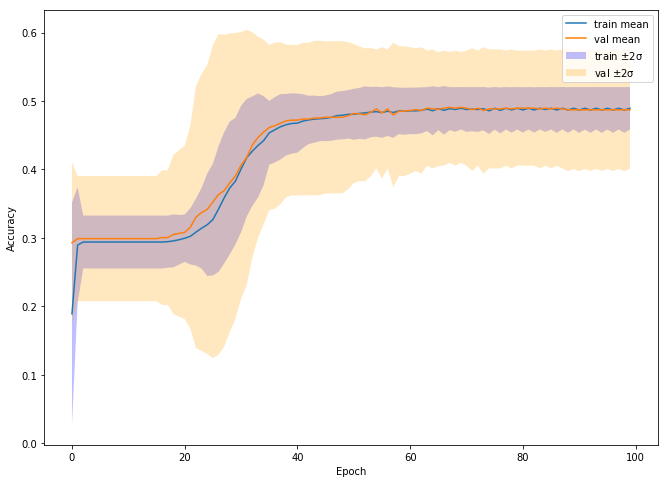

In [21]:
plot_stats('Accuracy', acc_history, val_acc_history)

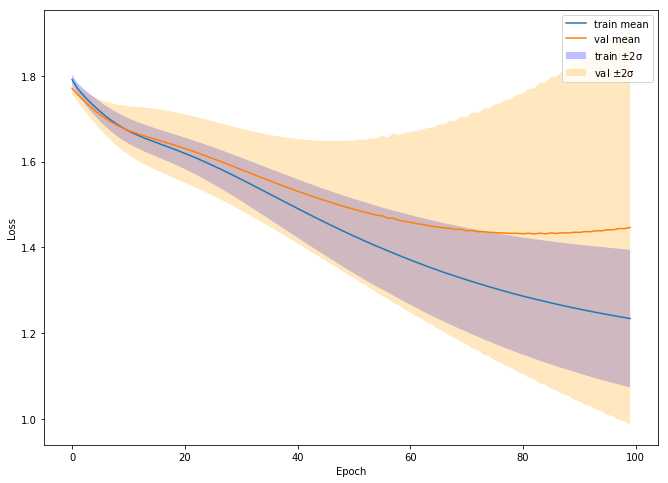

In [22]:
plot_stats('Loss', loss_history, val_loss_history)